In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
%pip install -U ddgs

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install -qU "langchain-google-community[gmail]"

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install --upgrade --quiet langchain-community arxiv

Note: you may need to restart the kernel to use updated packages.


In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)
small_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [6]:
from langchain_core.tools import tool


@tool
def add(a: int, b: int) -> int:
    """Add two numbers."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

In [7]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()

In [8]:
from langchain_google_community import GmailToolkit
from langchain_google_community.gmail.utils import (
  build_resource_service,
  get_gmail_credentials
)

SCOPES = [
    "https://www.googleapis.com/auth/gmail.readonly",
    "https://www.googleapis.com/auth/gmail.compose",
    "https://www.googleapis.com/auth/gmail.send",
]

credentials = get_gmail_credentials(
    token_file="./google/gmail_token.json",
    scopes=SCOPES,
    client_sercret_file="./google/gmail_credentials.json",
)

api_resource = build_resource_service(credentials=credentials)
gmail_toolKit = GmailToolkit(api_resource=api_resource)
gmail_tool_list = gmail_toolKit.get_tools()

C:\Users\jo\AppData\Local\Temp\ipykernel_35216\523952650.py:13: DeprecationWarning: get_gmail_credentials is deprecated and will be removed in a future version.Use get_google_credentials instead.
  credentials = get_gmail_credentials(
C:\Users\jo\AppData\Local\Temp\ipykernel_35216\523952650.py:19: DeprecationWarning: build_resource_service is deprecated and will be removed in a future version.Use build_gmail_service instead.
  api_resource = build_resource_service(credentials=credentials)


In [9]:
from langchain_community.agent_toolkits.load_tools import load_tools

loaded_tool_list = load_tools(
  ["arxiv"]
)

In [10]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools.retriever import create_retriever_tool

embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = Chroma(
  embedding_function=embedding_function,
  collection_name="real_estate_tax",
  persist_directory="./chroma_db"  # ✅ 디렉터리
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})
retriever_tool = create_retriever_tool(
  retriever=retriever,
  name='real_estate_tax_retriever',
  description='Useful for answering questions about real estate tax in South Korea.'
)

In [11]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply, search_tool, retriever_tool] + gmail_tool_list + loaded_tool_list
llm_with_tools = llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

In [12]:
from langgraph.graph import MessagesState, StateGraph

class AgentState(MessagesState):
    summary: str

graph_builder = StateGraph(AgentState)

In [ ]:
from langchain_core.messages import SystemMessage

def agent(state: AgentState) :
    messages = state['messages']
    summary = state['summary']
    if summary != '':
        messages = [SystemMessage(content=f'Here is the summary of previous conversation: {summary}')] + messages
    response = llm_with_tools.invoke(messages)
    return {'messages' : [response]}

In [14]:
def summarize_messages(state : AgentState):
    messages = state['messages']
    summary = state['summary']
    summary_prompt = f'summarize this chat history below: \n\nchat_history:{messages}'
    if summary != '':
        summary_prompt = f'''summarize this chat history below while looking at the summary of earlier conversations
    chat_history:{messages}
    summary : {summary}
    ''' 

    summary = small_llm.invoke(summary_prompt)
    response = llm_with_tools.invoke(messages)
    return {'summary' : response.content}

In [15]:
from langchain_core.messages import RemoveMessage

def delete_messages(state : AgentState):
  messages = state['messages']
  delete_message = [RemoveMessage(id=message.id) for message in messages[:-3]]
  return {'messages' : delete_message}

In [16]:
from langgraph.graph import END

def should_continue(state : AgentState):
    message = state['messages']
    last_ai_message = message[-1]
    if last_ai_message.tool_calls:
        return 'tools'
    return 'summarize_messages'

In [17]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)
graph_builder.add_node(delete_messages)
graph_builder.add_node(summarize_messages)

In [18]:
from langgraph.graph import START, END
graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
  'agent',
   should_continue,
   ['tools', 'summarize_messages']
)
graph_builder.add_edge('tools', 'agent')
graph_builder.add_edge('summarize_messages', 'delete_messages')
graph_builder.add_edge('delete_messages', END)

In [19]:
from langgraph.checkpoint.memory import MemorySaver

checkPointer = MemorySaver()

graph = graph_builder.compile(
    checkpointer=checkPointer
)

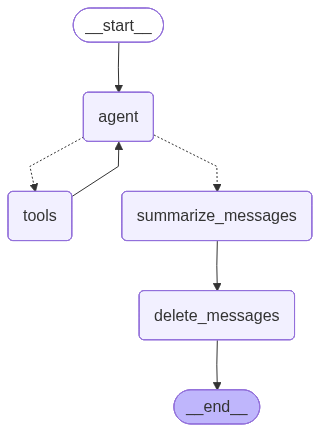

In [20]:
from IPython.display import Image, display

png_bytes = graph.get_graph().draw_mermaid_png()
display(Image(data=png_bytes))

In [27]:
from langchain_core.messages import HumanMessage

config = {
    'configurable' : {
        'thread_id' : 'paper_summary'
    }
}


query = 'nicednjsdud@gmail.com으로 Attention Is All You Need 논문을 요약해서 이메일 초안을 작성해주세요.'
for chunk in graph.stream({'messages': [HumanMessage(query)], 'summary': ''}, config = config, stream_mode='values') :
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

nicednjsdud@gmail.com으로 Attention Is All You Need 논문을 요약해서 이메일 초안을 작성해주세요.
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_U1XC429NSneXP69DMZS3c3yr)
 Call ID: call_U1XC429NSneXP69DMZS3c3yr
  Args:
    query: Attention Is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2021-05-06
Title: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet
Authors: Luke Melas-Kyriazi
Summary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifically, we replace the attention

In [28]:
current_message_list = graph.get_state(config).values['messages']
current_message_list

[AIMessage(content='I couldn\'t find the specific summary for the "Attention Is All You Need" paper. However, I can provide a general summary based on my knowledge:\n\nThe "Attention Is All You Need" paper introduces the Transformer model, which is a novel architecture for sequence transduction tasks. The key innovation of the Transformer is the use of self-attention mechanisms, which allow the model to weigh the importance of different words in a sentence when encoding and decoding sequences. This approach eliminates the need for recurrent layers, making the model more parallelizable and efficient. The Transformer has been highly influential, leading to significant advancements in natural language processing tasks.\n\nNow, I will create an email draft with this summary.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 273, 'prompt_tokens': 2020, 'total_tokens': 2293, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tok

In [31]:
graph.get_state(config).values['summary']

'I couldn\'t find the specific summary for the "Attention Is All You Need" paper. However, I can provide a general summary based on my knowledge:\n\nThe "Attention Is All You Need" paper introduces the Transformer model, which is a novel architecture for sequence transduction tasks. The key innovation of the Transformer is the use of self-attention mechanisms, which allow the model to weigh the importance of different words in a sentence when encoding and decoding sequences. This approach eliminates the need for recurrent layers, making the model more parallelizable and efficient. The Transformer has been highly influential, leading to significant advancements in natural language processing tasks.\n\nNow, I will create an email draft with this summary.'

In [23]:

# for index, message in enumerate(current_message_list):
#     if index < len(current_message_list) - 1:
#         graph.update_state(config, {'messages': RemoveMessage(id = message.id)})

In [29]:
update_query = '논문의 출처 url를 첨부해주세요.'
for chunk in graph.stream({'messages': [HumanMessage(update_query)]}, config = config, stream_mode='values') :
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

논문의 출처 url를 첨부해주세요.
================================== Ai Message ==================================

The "Attention Is All You Need" paper can be accessed on arXiv at the following URL: [https://arxiv.org/abs/1706.03762](https://arxiv.org/abs/1706.03762).

I will update the email draft to include this URL.
Tool Calls:
  create_gmail_draft (call_Gv7bNEcmyULDQvXNRO6PP3DH)
 Call ID: call_Gv7bNEcmyULDQvXNRO6PP3DH
  Args:
    message: The "Attention Is All You Need" paper introduces the Transformer model, which is a novel architecture for sequence transduction tasks. The key innovation of the Transformer is the use of self-attention mechanisms, which allow the model to weigh the importance of different words in a sentence when encoding and decoding sequences. This approach eliminates the need for recurrent layers, making the model more parallelizable and efficient. The Transformer has been highly influential,

In [ ]:
update_query = '초안이 좋습니다. 한글로 번역해서 이메일로 전송해주세요.'
for chunk in graph.stream({'messages': [HumanMessage(update_query)]}, config = config, stream_mode='values') :
    chunk['messages'][-1].pretty_print()